<a href="https://colab.research.google.com/github/W-mauyon/PROPEL-JHU-EEHPC-Research/blob/main/Image_Classification_Neural_Network_for_JHU_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random

In [49]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [50]:
class PreSSMClassifier(nn.Module):
    def __init__(self, input_dim=784, d_model=128, conv_kernel_size=4, num_classes=10):
        super(PreSSMClassifier, self).__init__()

        self.linear_proj1 = nn.Linear(
            input_dim,
            d_model)

        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=d_model,
            kernel_size=conv_kernel_size,
            padding=conv_kernel_size//2)

        self.silu = nn.SiLU()

        self.linear_proj2 = nn.Linear(d_model, d_model)

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.linear_proj1(x)

        x = x.unsqueeze(1)

        x = self.conv1d(x)

        x = self.silu(x)

        x = x.mean(dim=2)

        x = self.linear_proj2(x)

        logits = self.classifier(x)
        return logits

In [51]:
device = torch.device("cpu")
model = PreSSMClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
epochs= 5
losses = []
def train_model(epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

        losses.append(total_loss)
        accuracy = 100. * correct / len(train_loader.dataset)
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%')

In [53]:
def test_model():
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(dim=1) == labels).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy:.2f}%')

Epoch 1: Loss = 0.9538, Accuracy = 66.75%
Epoch 2: Loss = 0.3668, Accuracy = 89.28%
Epoch 3: Loss = 0.2521, Accuracy = 92.68%
Epoch 4: Loss = 0.2010, Accuracy = 94.26%
Epoch 5: Loss = 0.1692, Accuracy = 95.09%
Test Accuracy: 94.39%


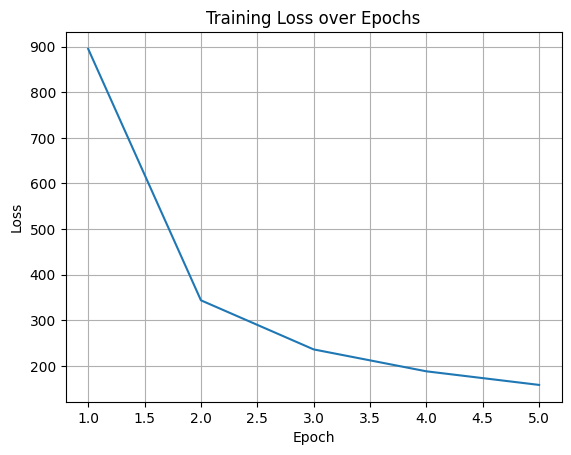

In [54]:
train_model(epochs=5)
test_model()

plt.plot(range(1, epochs+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

In [55]:
x_test_samples = []
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        x_test_samples.append(images)
        true_labels.append(labels)
        predicted_labels.append(preds)

x_test_samples = torch.cat(x_test_samples)
true_labels = torch.cat(true_labels)
predicted_labels = torch.cat(predicted_labels)

In [56]:
def visualize_predictions(x_test, predicted_labels, true_labels):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        index = random.randint(0, len(x_test) - 1)
        image = x_test[index].reshape(28, 28)

        plt.subplot(2, 5, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Pred: {predicted_labels[index].item()}, True: {true_labels[index].item()}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

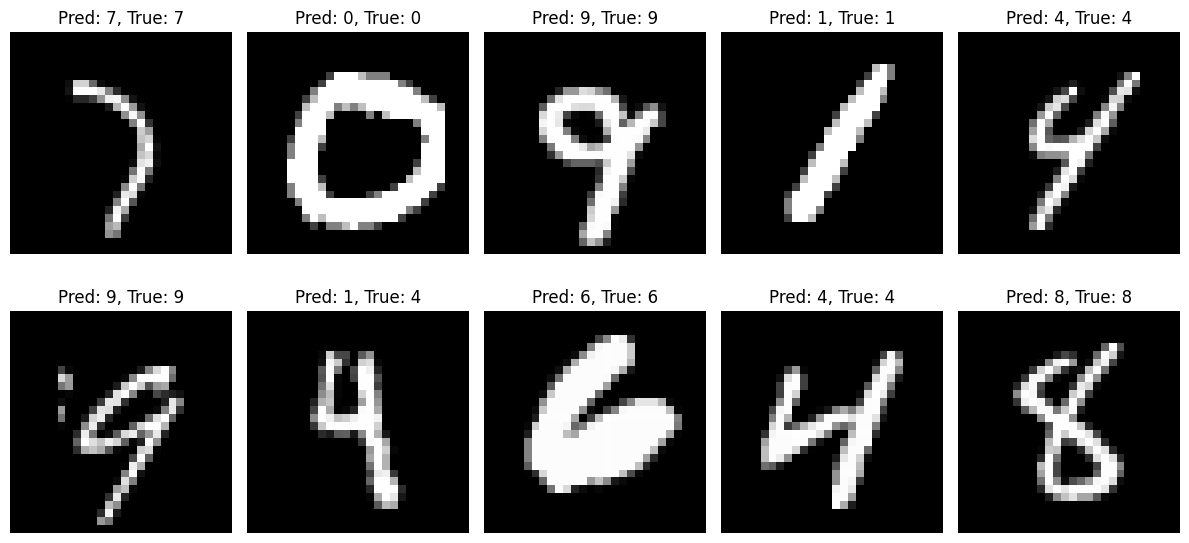

In [57]:
visualize_predictions(x_test_samples,predicted_labels, true_labels)

In [58]:
Q_SCALE = 2 ** 11  # For Q5.11

def to_fixed_point(tensor, scale=Q_SCALE):
    scaled = np.round(tensor.cpu().numpy() * scale)
    max_val = np.max(scaled)
    min_val = np.min(scaled)
    print(f"Fixed-point scaling: max={max_val}, min={min_val}")
    clipped = np.clip(scaled, -32768, 32767).astype(np.int16)
    return clipped

def save_mem_file(filename, data):
    with open(filename, 'w') as f:
        for val in data.flatten():
            f.write(f"{int(val) & 0xFFFF:04X}\n")
    print(f"Saved {filename} with shape {data.shape}")

def export_model_weights(model):
    lp1_weight = to_fixed_point(model.linear_proj1.weight.data)
    lp1_bias = to_fixed_point(model.linear_proj1.bias.data)

    save_mem_file('proj1_weights.mem', lp1_weight)
    save_mem_file('proj1_biases.mem', lp1_bias)

    # Conv1D
    conv_weight = to_fixed_point(model.conv1d.weight.data)
    conv_bias = to_fixed_point(model.conv1d.bias.data)

    save_mem_file('conv1d_weights.mem', conv_weight)
    save_mem_file('conv1d_biases.mem', conv_bias)

    # Linear Projection 2
    lp2_weight = to_fixed_point(model.linear_proj2.weight.data)
    lp2_bias = to_fixed_point(model.linear_proj2.bias.data)

    save_mem_file('proj2_weights.mem', lp2_weight)
    save_mem_file('proj2_biases.mem', lp2_bias)

    # Classifier (if needed)
    classifier_weight = to_fixed_point(model.classifier.weight.data)
    classifier_bias = to_fixed_point(model.classifier.bias.data)

    save_mem_file('classifier_weights.mem', classifier_weight)
    save_mem_file('classifier_biases.mem', classifier_bias)

In [59]:
export_model_weights(model)

Fixed-point scaling: max=1201.0, min=-1048.0
Fixed-point scaling: max=1511.0, min=-1631.0
Saved proj1_weights.mem with shape (128, 784)
Saved proj1_biases.mem with shape (128,)
Fixed-point scaling: max=1651.0, min=-1778.0
Fixed-point scaling: max=957.0, min=-1142.0
Saved conv1d_weights.mem with shape (128, 1, 4)
Saved conv1d_biases.mem with shape (128,)
Fixed-point scaling: max=1123.0, min=-1256.0
Fixed-point scaling: max=403.0, min=-330.0
Saved proj2_weights.mem with shape (128, 128)
Saved proj2_biases.mem with shape (128,)
Fixed-point scaling: max=1000.0, min=-899.0
Fixed-point scaling: max=237.0, min=-196.0
Saved classifier_weights.mem with shape (10, 128)
Saved classifier_biases.mem with shape (10,)


In [60]:
image_idx = 0
image_tensor, label = mnist_test[image_idx]

# Convert image to Q5.11
image_np = image_tensor.numpy()
q5_11_image = np.round(image_np * Q_SCALE).astype(np.int16)

np.savetxt("mnist_sample_q5_11.txt", q5_11_image, fmt='%d')

print(f"Image index {image_idx} with label {label} converted and saved as mnist_sample_q5_11.txt")

Image index 0 with label 7 converted and saved as mnist_sample_q5_11.txt
